<a href="https://colab.research.google.com/github/zxcej/COMP691_LABS/blob/main/starter_code_Assig3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use the below model for **1 (a) - (c)**

Training MNIST classifier
Epoch: 1/20, Train Loss: 0.2859, Test Acc: 0.9810
Epoch: 2/20, Train Loss: 0.0491, Test Acc: 0.9826
Epoch: 3/20, Train Loss: 0.0339, Test Acc: 0.9852
Epoch: 4/20, Train Loss: 0.0270, Test Acc: 0.9879
Epoch: 5/20, Train Loss: 0.0222, Test Acc: 0.9921
Epoch: 6/20, Train Loss: 0.0200, Test Acc: 0.9910
Epoch: 7/20, Train Loss: 0.0161, Test Acc: 0.9903
Epoch: 8/20, Train Loss: 0.0165, Test Acc: 0.9882
Epoch: 9/20, Train Loss: 0.0129, Test Acc: 0.9923
Epoch: 10/20, Train Loss: 0.0123, Test Acc: 0.9933
Epoch: 11/20, Train Loss: 0.0107, Test Acc: 0.9915
Epoch: 12/20, Train Loss: 0.0108, Test Acc: 0.9904
Epoch: 13/20, Train Loss: 0.0102, Test Acc: 0.9931
Epoch: 14/20, Train Loss: 0.0076, Test Acc: 0.9934
Epoch: 15/20, Train Loss: 0.0079, Test Acc: 0.9905
Epoch: 16/20, Train Loss: 0.0076, Test Acc: 0.9908
Epoch: 17/20, Train Loss: 0.0058, Test Acc: 0.9933
Epoch: 18/20, Train Loss: 0.0052, Test Acc: 0.9911
Epoch: 19/20, Train Loss: 0.0066, Test Acc: 0.9910
Epoch: 20/20, 

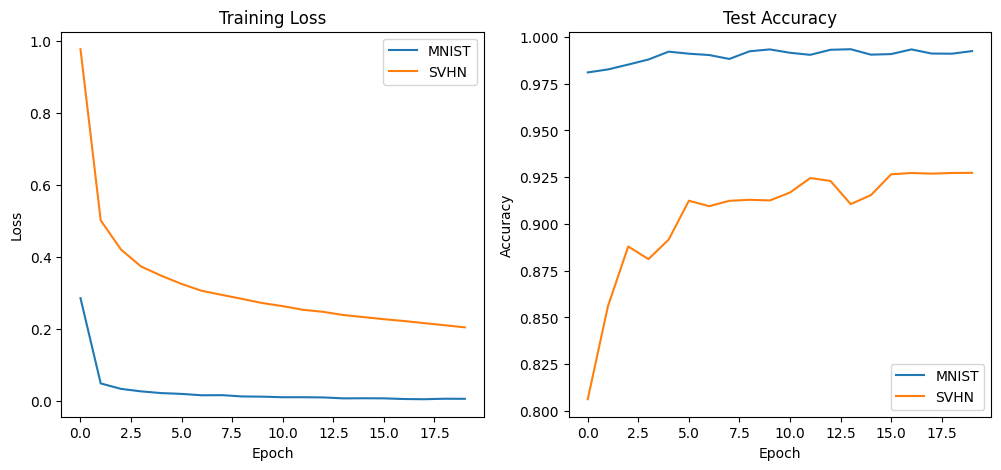

Final test accuracy for MNIST: 0.9924
Final test accuracy for SVHN: 0.9273


In [30]:
import torch.nn as nn

feature_model = nn.Sequential(nn.Conv2d(1, 32, 5), nn.BatchNorm2d(32), nn.ReLU(), 
                      nn.MaxPool2d(2, stride=2),
                      nn.Conv2d(32, 64, 5), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.Conv2d(64, 64, 3), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

# For (b)-(c) add the task heads on top of the feature_model
# Note this model can adapt the averaging to the size so inputs of 32x32 and 28x28 both work
# Grayscale conversion for SVHN, you may use transforms.Grayscale(num_output_channels=1) found in torchvision

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np

# Load the data
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transforms.ToTensor())

svhn_train_gray = torchvision.datasets.SVHN(root='./data', split='train', download=False, transform= transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()]))
svhn_test_gray = torchvision.datasets.SVHN(root='./data', split='test', download=False, transform= transforms.Compose([transforms.Grayscale(num_output_channels=1), transforms.ToTensor()]))

# #show some images
# def show_images(images, labels):
#     plt.figure(figsize=(10, 10))
#     for i in range(25):
#         plt.subplot(5, 5, i+1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         plt.imshow(np.transpose(images[i], (1, 2, 0)))
#         plt.xlabel(labels[i])
#     plt.show()

# random_indices = np.random.randint(0, len(mnist_train), 25)
# show_images([svhn_train[i][0] for i in random_indices], [svhn_train[i][1] for i in random_indices])

batch_size = 128
learning_rate = 0.001
num_epochs = 20

# Create the dataloaders
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

svhn_train_loader = DataLoader(svhn_train_gray, batch_size=batch_size, shuffle=True)
svhn_test_loader = DataLoader(svhn_test_gray, batch_size=batch_size, shuffle=False)


class Classifier(nn.Module):
    def __init__(self, feature_model, num_classes):
        super(Classifier, self).__init__()
        self.feature_model = feature_model
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.feature_model(x)
        x = self.classifier(x)
        return x
    

# Train and evaluate functions

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    return running_loss / len(train_loader.dataset)

def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, pred = torch.max(output, 1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    return correct / total

def train_and_evaluate(model, train_loader, test_loader, device, num_epochs, learning_rate):
    train_loss_arr = []
    test_acc_arr = []
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_acc = evaluate(model, test_loader, device)
        train_loss_arr.append(train_loss)
        test_acc_arr.append(test_acc)
        print('Epoch: {}/{}, Train Loss: {:.4f}, Test Acc: {:.4f}'.format(epoch+1, num_epochs, train_loss, test_acc))
    return train_loss_arr, test_acc_arr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Train MNIST classifier
print ('Training MNIST classifier')
mnist_classifier = Classifier(feature_model, 10).to(device)
mnist_train_loss_arr, mnist_test_acc_arr = train_and_evaluate(mnist_classifier, mnist_train_loader, mnist_test_loader, device, num_epochs, learning_rate)

#Train SVHN classifier
print ('Training SVHN classifier')
svhn_classifier = Classifier(feature_model, 10).to(device)
svhn_train_loss_arr, svhn_test_acc_arr = train_and_evaluate(svhn_classifier, svhn_train_loader, svhn_test_loader, device, num_epochs, learning_rate)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mnist_train_loss_arr, label='MNIST')
plt.plot(svhn_train_loss_arr, label='SVHN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(mnist_test_acc_arr, label='MNIST')
plt.plot(svhn_test_acc_arr, label='SVHN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Test Accuracy')

plt.show()


print(f"Final test accuracy for MNIST: {mnist_test_acc_arr[-1]:.4f}")
print(f"Final test accuracy for SVHN: {svhn_test_acc_arr[-1]:.4f}")






***Question*** **1 (c)**

Traning and evaluating multi-task model...
Epoch: 1/20, Train Loss: 0.2524, MNIST Test Acc: 0.9051, SVHN Test Acc: 0.9222
Epoch: 2/20, Train Loss: 0.1793, MNIST Test Acc: 0.8242, SVHN Test Acc: 0.9138
Epoch: 3/20, Train Loss: 0.1663, MNIST Test Acc: 0.9416, SVHN Test Acc: 0.9173
Epoch: 4/20, Train Loss: 0.1576, MNIST Test Acc: 0.8735, SVHN Test Acc: 0.9251
Epoch: 5/20, Train Loss: 0.1496, MNIST Test Acc: 0.8709, SVHN Test Acc: 0.9019
Epoch: 6/20, Train Loss: 0.1456, MNIST Test Acc: 0.9277, SVHN Test Acc: 0.9198
Epoch: 7/20, Train Loss: 0.1406, MNIST Test Acc: 0.9161, SVHN Test Acc: 0.9333
Epoch: 8/20, Train Loss: 0.1364, MNIST Test Acc: 0.8735, SVHN Test Acc: 0.9300
Epoch: 9/20, Train Loss: 0.1330, MNIST Test Acc: 0.9144, SVHN Test Acc: 0.9319
Epoch: 10/20, Train Loss: 0.1276, MNIST Test Acc: 0.9277, SVHN Test Acc: 0.9330
Epoch: 11/20, Train Loss: 0.1244, MNIST Test Acc: 0.9048, SVHN Test Acc: 0.9361
Epoch: 12/20, Train Loss: 0.1223, MNIST Test Acc: 0.8492, SVHN Test Acc: 0.9352
Epoch:

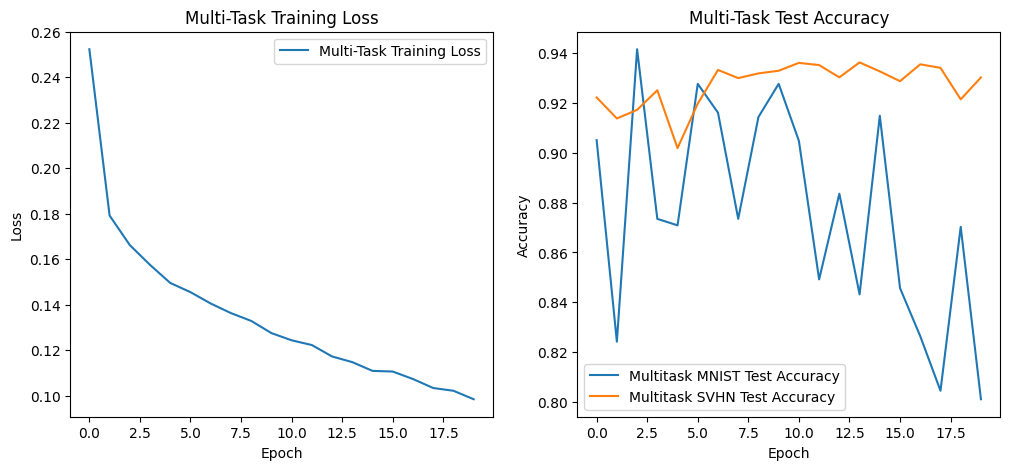

Final multitask test accuracy for MNIST: 0.8011
Final multitask test accuracy for SVHN: 0.9303


In [37]:
#Write a multi-task learning model

import itertools

class MultiTaskClassifier(nn.Module):
    def __init__(self, feature_model, num_classes):
        super(MultiTaskClassifier, self).__init__()
        self.feature_model = feature_model
        self.head_mnist = nn.Sequential(
            nn.Linear(64,64), nn.ReLU(), nn.Linear(64, num_classes)
        )
        self.head_svhn = nn.Sequential(
            nn.Linear(64,64), nn.ReLU(), nn.Linear(64, num_classes)
        )

    def forward(self, x, task):
        x = self.feature_model(x)
        if task == 'mnist':
            x = self.head_mnist(x)
        elif task == 'svhn':
            x = self.head_svhn(x)
        return x
    
# Train and evaluate functions

def multi_task_train(model, mnist_dataloader, svhn_dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for mnist_tuple, svhn_tuple in itertools.zip_longest(mnist_dataloader, svhn_dataloader):
        if mnist_tuple is not None:
            mnist_data, mnist_target = mnist_tuple
            mnist_data, mnist_target = mnist_data.to(device), mnist_target.to(device)
            optimizer.zero_grad()
            mnist_output = model(mnist_data, 'mnist')
            mnist_loss = criterion(mnist_output, mnist_target)
            mnist_loss.backward()
            optimizer.step()
            running_loss += mnist_loss.item() * mnist_data.size(0)
    
        if svhn_tuple is not None:
            svhn_data, svhn_target = svhn_tuple
            svhn_data, svhn_target = svhn_data.to(device), svhn_target.to(device)
            optimizer.zero_grad()
            svhn_output = model(svhn_data, 'svhn')
            svhn_loss = criterion(svhn_output, svhn_target)
            svhn_loss.backward()
            optimizer.step()
            running_loss += svhn_loss.item() * svhn_data.size(0)
            
    return running_loss / (len(mnist_dataloader.dataset) + len(svhn_dataloader.dataset))

def multi_task_evaluate(model, mnist_dataloader, svhn_dataloader, device):
    model.eval()
    mnist_correct = 0
    mnist_total = 0
    svhn_correct = 0
    svhn_total = 0
    with torch.no_grad():
        for mnist_tuple, svhn_tuple in itertools.zip_longest(mnist_dataloader, svhn_dataloader):
            if mnist_tuple is not None:
                mnist_data, mnist_target = mnist_tuple
                mnist_data, mnist_target = mnist_data.to(device), mnist_target.to(device)
                mnist_output = model(mnist_data, 'mnist')
                _, mnist_pred = torch.max(mnist_output, 1)
                mnist_correct += (mnist_pred == mnist_target).sum().item()
                mnist_total += mnist_target.size(0)
            
            if svhn_tuple is not None:
                svhn_data, svhn_target = svhn_tuple
                svhn_data, svhn_target = svhn_data.to(device), svhn_target.to(device)
                svhn_output = model(svhn_data, 'svhn')
                _, svhn_pred = torch.max(svhn_output, 1)
                svhn_correct += (svhn_pred == svhn_target).sum().item()
                svhn_total += svhn_target.size(0)

    mnist_acc = mnist_correct / mnist_total
    svhn_acc = svhn_correct / svhn_total
    return mnist_acc, svhn_acc

def multi_task_train_and_evaluate(model, mnist_train_loader, mnist_test_loader, svhn_train_loader, svhn_test_loader, device, num_epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss_arr = []
    mnist_test_acc_arr = []
    svhn_test_acc_arr = []
    for epoch in range(num_epochs):
        train_loss = multi_task_train(model, mnist_train_loader, svhn_train_loader, criterion, optimizer, device)
        mnist_test_acc, svhn_test_acc = multi_task_evaluate(model, mnist_test_loader, svhn_test_loader, device)
        train_loss_arr.append(train_loss)
        mnist_test_acc_arr.append(mnist_test_acc)
        svhn_test_acc_arr.append(svhn_test_acc)
        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, MNIST Test Acc: {mnist_test_acc:.4f}, SVHN Test Acc: {svhn_test_acc:.4f}")
    return train_loss_arr, mnist_test_acc_arr, svhn_test_acc_arr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 64

mnist_train_half_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_test_half_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
svhn_train_half_loader = DataLoader(svhn_train_gray, batch_size=batch_size, shuffle=True)
svhn_test_half_loader = DataLoader(svhn_test_gray, batch_size=batch_size, shuffle=False)



print("Traning and evaluating multi-task model...")
multitask_model = MultiTaskClassifier(feature_model, num_classes=10).to(device)
multitask_loss_arr, multitask_mnist_test_acc_arr, multitask_svhn_test_acc_arr = multi_task_train_and_evaluate(multitask_model, mnist_train_half_loader, mnist_test_half_loader, svhn_train_half_loader, svhn_test_half_loader, device, num_epochs, learning_rate)

# Plot the training loss and test accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(multitask_loss_arr, label='Multi-Task Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Multi-Task Training Loss')

plt.subplot(1,2,2)
plt.plot(multitask_mnist_test_acc_arr, label='Multitask MNIST Test Accuracy')
plt.plot(multitask_svhn_test_acc_arr, label='Multitask SVHN Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Multi-Task Test Accuracy')
plt.show()


print(f"Final multitask test accuracy for MNIST: {multitask_mnist_test_acc_arr[-1]:.4f}")
print(f"Final multitask test accuracy for SVHN: {multitask_svhn_test_acc_arr[-1]:.4f}")








    



***Question*** **1 (d)**

In this question we will train a joint embedding between a model embedding from MNIST and a model embedding from SVHN dataset, both digit datasets. Your specific task to evaluate this will be to try to obtain $70\%$ or higher accuracy on the MNIST classification by embedding MNIST test digits and then searching for the 1-nearest neighbor SVHN digit and using it's category to classify.  

First we will define the mnist and svhn models. For svhn we will use a pre-trained model that can already classify svhn digits. The models are defined below 

In [76]:
## MNIST model
model_mnist = nn.Sequential(nn.Conv2d(1, 32, 5), nn.BatchNorm2d(32), nn.ReLU(), #For (e) use SVHN nn.Conv2d(3,32,5)
                      nn.MaxPool2d(2, stride=2),
                      nn.Conv2d(32, 64, 5), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.Conv2d(64, 64, 3), nn.BatchNorm2d(64), nn.ReLU(),
                      nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

from torch.utils import model_zoo
from collections import OrderedDict
### SVHN model, we will download one that is already trained to clasify svhn digits
model_urls = {
    'svhn': 'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/svhn-f564f3d8.pth',
}

class SVHN(nn.Module):
    def __init__(self, features, n_channel, num_classes):
        super(SVHN, self).__init__()
        assert isinstance(features, nn.Sequential), type(features)
        self.features = features

        #We won't use this classifier
        self.classifier = nn.Sequential(
            nn.Linear(n_channel, num_classes)
        )
        print(self.features)
        print(self.classifier)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for i, v in enumerate(cfg):
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            padding = v[1] if isinstance(v, tuple) else 1
            out_channels = v[0] if isinstance(v, tuple) else v
            conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(out_channels, affine=False), nn.ReLU(), nn.Dropout(0.3)]
            else:
                layers += [conv2d, nn.ReLU(), nn.Dropout(0.3)]
            in_channels = out_channels
    return nn.Sequential(*layers)

def svhn_model(n_channel, pretrained=None):
    cfg = [n_channel, n_channel, 'M', 2*n_channel, 2*n_channel, 'M', 4*n_channel, 4*n_channel, 'M', (8*n_channel, 0), 'M']
    layers = make_layers(cfg, batch_norm=True)
    model = SVHN(layers, n_channel=8*n_channel, num_classes=10)
    if pretrained is not None:
        m = model_zoo.load_url(model_urls['svhn'])
        state_dict = m.state_dict() if isinstance(m, nn.Module) else m
        assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
        model.load_state_dict(state_dict)

    return model


base_svhn = svhn_model(n_channel=32,pretrained=True).features
svhn_to_joint = nn.Linear(256,64)

model_svhn = nn.Sequential(base_svhn, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), svhn_to_joint)


#Transformation for SVHN data, you need to use this normalization for the pre-trained model to work properly 
transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ])

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.3, inplace=False)
  (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (15): ReLU()
  (16): Dropout(p=0.3, inplace=False)
  (17): MaxPool2d(kernel_size=2, stride=2, padding=0

Let's denote model_mnist above as $f_{\theta}(x)$, the pre_trained model $g_{\gamma}$ and svhn_to_joint as the matrix $W$. Finally model_svhn corresponds to $WAg_{\gamma}(x)$. Here A (nn.AdaptiveAvgPool2d) is the averaging operator and has no parameters. Thus model_svhn will map svhn digits to a joint space and model_mnist will map MNIST digits to the joint space.  We will keep $g_{
\gamma}$ fixed and update $\theta, W$.  You should optimize the following objective that is a sum of two loss functions over triplets


$$\min_{\theta, W} \sum_{x_a,x_p,x_n \in \textbf{M}} max(0, \|f_{\theta}(x_a) - WAg_{\gamma}(x_p) \|-\|f_{\theta}(x_a) - WAg_{\gamma}(x_n) \|+\alpha) +\sum_{x_a,x_p,x_n \in \textbf{S}} max(0, \|f_{\theta}(x_p) - WAg_{\gamma}(x_a) \|-\|f_{\theta}(x_n) - WAg_{\gamma}(x_a) \|+\alpha)$$ 


Here $\textbf{M}$ is the set of triplets with anchors from MNIST data, positives from SVHN (matching the anchor class), and negatives from SVHN (with different class from anchors). Similarly $\textbf{S}$ is the set of triplets with anchors from SVHN data, positives from MNIST (matching anchor class), and negatives from MNIST not matching anchor class. You can use nn.TripletMarginLoss to implement this.  

During training with a stochastic optimizer we will sample subsets of $M$ and $S$ for each gradient update, there are various valid ways to sample this as will be discussed.

Note we only optimize W and $\theta$, below see an example how to build the optimizer. Note we want to freeze the $g_{\gamma}$ model so we will also need to disable the dropout and batchnorm. 

In [88]:
from torch import optim
optimizer = optim.Adam(list(model_mnist.parameters()) + list(svhn_to_joint.parameters()), lr=1e-3) # you may experiment with different learning rates
model_svhn.eval() #IMPORTANT: BEFORE running set to eval even for training to avoid dropout, we want to keep this fixed except the final layer, otherwise training will need to be much longer

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.3, inplace=False)
    (13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (15): ReLU()
    (16): Dropout(p=0.3, inplace=False)

**Suggested settings:** learning rate 1e-5 with Adam, margin ($\alpha$) of 0.2, batch size: 256 triplets samples $M$ and 256 from $S$, 1000 training iterations (not epochs, but gradient updates/minibatch processed, aka it can be trained fast!). You may modify these as you see fit.

Data augmentation is not required to make this work but you may use it if you like. For SVHN you must use the normalization above (transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))) so that the pre-trained SVHN model works. 

**Sampling the triplets** There are various valid ways you could construct the triplet sets $\textbf{M, S}$ and sample from them. For example you could enumerate all possible triplets over the dataset and select batches of these. A quick and dirty on the fly method that allows to use standard dataloaders is as follows: Sample a minibatch of size N (say 256) from both SVHN and MNIST using standard dataloaders from classification tasks. Treat all SVHN digits in this batch as  anchors, from the MNIST minibatch data find appropriate positives and negatives for each SVHN digit. For the second part of the loss treat the MNIST data as anchors and find negatives and postivies from the SVHN minibatch. Partial code snippets to construct this is shown below (note this code would give triplets for $\textbf{M}$ part only). You may also use your own approach to sample the triplet sets.

Note: if you would like to use hard negative mining (not required) a more sophisticated approach would be needed. Below is a code snippet example of how one could pick the positives using the labels for each minibatch.

In [45]:
# import random
# def sample_triplets(anchor_set, positive_set, negative_set):
#     padding_layer = nn.ConstantPad2d(2, 0)
#     triplets = []

#     for anchor_label, anchor_img in zip(anchor_set[1], anchor_set[0]):
#         # Find positive samples
#         positive_indices = [i for i, positive_label in enumerate(positive_set[1]) if positive_label == anchor_label]
#         positive_img = positive_set[0][random.choice(positive_indices)]

#         # Find negative samples
#         negative_indices = [i for i, negative_label in enumerate(negative_set[1]) if negative_label != anchor_label]
#         negative_img = negative_set[0][random.choice(negative_indices)]

#         # Pad MNIST images if necessary
#         if anchor_img.shape[1] == 28:
#             anchor_img = padding_layer(anchor_img)
#         if positive_img.shape[1] == 28:
#             positive_img = padding_layer(positive_img)
#         if negative_img.shape[1] == 28:
#             negative_img = padding_layer(negative_img)

#         triplets.append((anchor_img, positive_img, negative_img))

#     return triplets

In [89]:
#s_labels is a vector with batch_size labels (0-9) for a minibatch of SVHN digits
#m_labels is a vector with batch_size labels (0-9) for a minibatch of MNIST digits 

label_set = range(0,10)
label_to_indices = {label: np.where(s_labels.cpu().numpy() == label)[0]
                            for label in label_set}

                          
idx_pos = []
idx_neg = []
for lab in m_labels:
    positive_index = np.random.choice(label_to_indices[lab.item()])
    negative_label = np.random.choice(list(set(label_set) - set([lab.item()])))
    negative_index = np.random.choice(label_to_indices[negative_label])

    idx_pos.append(positive_index)
    idx_neg.append(negative_index)

#idx_pos and idx_neg can now can now be used to index the MNIST data minibatch to give positives and negatives
  

NameError: name 's_labels' is not defined

**Evaluation** For evaluating your embeddings use 2000 randomly selected SVHN digits from the SVHN training set embedding them with model_svhn. Use 100 randomly selected MNIST digits from the MNIST TEST set embedding them with model_mnist. The above numbers are chosen to avoid memory issues and reduce computation time, you may use larger amount of test inputs and embeddings if you wish. Assume the category data for the SVHN data is known and find for each MNIST digit the nearest SVHN digit. Report it's category as the prediction and compute the accuracy over all 100 MNIST digits. You should be able to obtain at least 70%+ although much higher accuracy is possible with a well tuned model. 

Finally for 3-5 MNIST digits show the top 5 SVHN sorted by lowest distance. 

In [90]:
from torch.nn import TripletMarginLoss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_mnist = model_mnist.to(device)
model_svhn = model_svhn.to(device)

# Loss function
triplet_loss = TripletMarginLoss(margin=0.2)


# Training loop
num_iterations = 1000
batch_size = 256

svhn_train_1d = torchvision.datasets.SVHN(root='./data', split='train', download=False, transform=transform)

mnist_train_loader_1d = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

svhn_train_loader_1d = DataLoader(svhn_train_1d, batch_size=batch_size, shuffle=True)

for iteration in range(num_iterations):
    mnist_batch, mnist_labels = next(iter(mnist_train_loader_1d))
    svhn_batch, svhn_labels = next(iter(svhn_train_loader_1d))

    mnist_batch = mnist_batch.to(device)
    mnist_labels = mnist_labels.to(device)
    svhn_batch = svhn_batch.to(device)
    svhn_labels = svhn_labels.to(device)

    label_set = range(0, 10)

    # M part
    label_to_indices_M = {label: np.where(svhn_labels.cpu().numpy() == label)[0]
                          for label in label_set}

    idx_pos_M = []
    idx_neg_M = []
    for lab in mnist_labels:
        positive_index = np.random.choice(label_to_indices_M[lab.item()])
        negative_label = np.random.choice(list(set(label_set) - set([lab.item()])))
        negative_index = np.random.choice(label_to_indices_M[negative_label])

        idx_pos_M.append(positive_index)
        idx_neg_M.append(negative_index)

    mnist_positives_M = mnist_batch[idx_pos_M]
    mnist_negatives_M = mnist_batch[idx_neg_M]

    mnist_anchors_M = model_svhn(svhn_batch)
    mnist_positives_M = model_mnist(mnist_positives_M)
    mnist_negatives_M = model_mnist(mnist_negatives_M)

    loss_M = triplet_loss(mnist_anchors_M, mnist_positives_M, mnist_negatives_M)

    # S part
    label_to_indices_S = {label: np.where(mnist_labels.cpu().numpy() == label)[0]
                          for label in label_set}

    idx_pos_S = []
    idx_neg_S = []
    for lab in svhn_labels:
        positive_index = np.random.choice(label_to_indices_S[lab.item()])
        negative_label = np.random.choice(list(set(label_set) - set([lab.item()])))
        negative_index = np.random.choice(label_to_indices_S[negative_label])

        idx_pos_S.append(positive_index)
        idx_neg_S.append(negative_index)

    svhn_positives_S = svhn_batch[idx_pos_S]
    svhn_negatives_S = svhn_batch[idx_neg_S]

    svhn_anchors_S = model_mnist(mnist_batch)
    svhn_positives_S = model_svhn(svhn_positives_S)
    svhn_negatives_S = model_svhn(svhn_negatives_S)

    loss_S = triplet_loss(svhn_anchors_S, svhn_positives_S, svhn_negatives_S)

    loss = loss_M + loss_S

    # Update the model parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iteration % 10 == 0:
        print(f'Iteration {iteration}, Loss: {loss.item()}, Loss_M: {loss_M.item()}, Loss_S: {loss_S.item()}')





Iteration 0, Loss: 0.41068214178085327, Loss_M: 0.19710908830165863, Loss_S: 0.21357306838035583
Iteration 10, Loss: 0.47474417090415955, Loss_M: 0.2176230549812317, Loss_S: 0.25712111592292786
Iteration 20, Loss: 0.4381759464740753, Loss_M: 0.21280454099178314, Loss_S: 0.22537140548229218
Iteration 30, Loss: 0.44366586208343506, Loss_M: 0.1981491893529892, Loss_S: 0.24551665782928467
Iteration 40, Loss: 0.4285748600959778, Loss_M: 0.19843846559524536, Loss_S: 0.23013639450073242
Iteration 50, Loss: 0.4385944902896881, Loss_M: 0.20219549536705017, Loss_S: 0.23639899492263794
Iteration 60, Loss: 0.4226255416870117, Loss_M: 0.20770487189292908, Loss_S: 0.21492068469524384
Iteration 70, Loss: 0.4152858853340149, Loss_M: 0.2001921534538269, Loss_S: 0.215093731880188
Iteration 80, Loss: 0.3949953615665436, Loss_M: 0.19438901543617249, Loss_S: 0.2006063461303711
Iteration 90, Loss: 0.4338657259941101, Loss_M: 0.191425621509552, Loss_S: 0.2424401044845581
Iteration 100, Loss: 0.41838711500167

KeyboardInterrupt: 

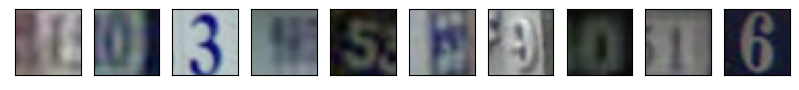

Accuracy: 8.00%


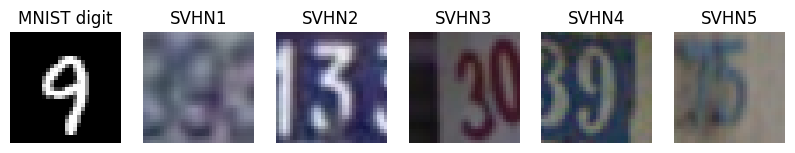

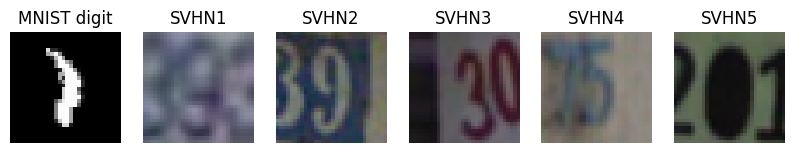

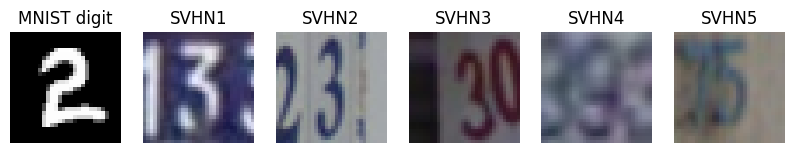

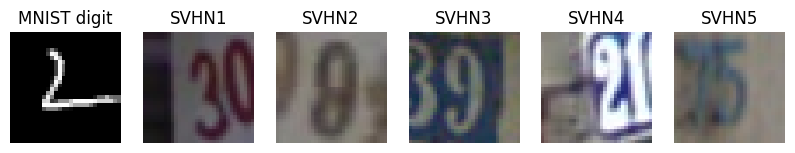

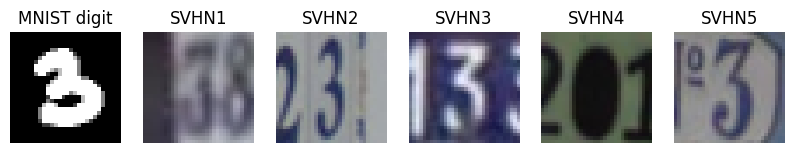

In [87]:
from sklearn.neighbors import KNeighborsClassifier

# Evaluation data, 100 
eval_mnist = [mnist_test[i] for i in torch.randint(0, len(mnist_test), (100,))]
eval_svhn = [svhn_train_1d[i] for i in torch.randint(0, len(svhn_train_1d), (2000,))]

#show some eval svhn images
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(eval_svhn[i][0], (1, 2, 0))*0.5+0.5)
plt.show()


# Compute embeddings
mnist_embeddings = model_mnist(torch.stack([x[0] for x in eval_mnist]).to(device)).cpu().detach().numpy()
svhn_embeddings = model_svhn(torch.stack([x[0] for x in eval_svhn]).to(device)).cpu().detach().numpy()

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(svhn_embeddings, [x[1] for x in eval_svhn])

#Predict the class of MNIST digits
pred = knn.predict(mnist_embeddings)

#Compute accuracy
acc = np.mean(pred == [x[1] for x in eval_mnist])

print("Accuracy: {:.2f}%".format(acc*100))

# Display the top 5 nearest SVHN neighbors for a few MNIST digits

num_mnist_to_display = 5

for i in range(num_mnist_to_display):
    mnists_digit = eval_mnist[i][0]
    mnist_embedding = mnist_embeddings[i]

    # Find the 5 nearest SVHN digit

    distances = np.linalg.norm(svhn_embeddings - mnist_embedding, axis=1)
    nearest_svhn_indices = np.argsort(distances)[:5]

    # Display the MNIST digit and the 5 nearest SVHN digits
    fig, axs = plt.subplots(1, 6, figsize=(10, 2))
    axs[0].imshow(mnists_digit.squeeze(), cmap='gray')
    axs[0].set_title("MNIST digit")
    axs[0].axis('off')

    for j, idx in enumerate(nearest_svhn_indices):
        svhn_digit = eval_svhn[idx][0]
        axs[j+1].imshow(np.transpose(svhn_digit, (1, 2, 0)) * 0.5 + 0.5)
        axs[j+1].set_title(f'SVHN{j+1}')
        axs[j+1].axis('off')
    
    plt.show()

If you run into memory issues you can move your model to CPU to process the SVHN encodings.

**Question Grading** If you have trouble getting this to work you may still get partial credit for appropriate methodology. Grading for this question will be as follows:

10 points - appropriate triplet construction and loss function construction

10 points - appropriate nearest neighbor classification evaluation setup 

10 points - obtaining above 70% accuracy, 5 points for getting above 50%

10 points  - visualization of the retrieval